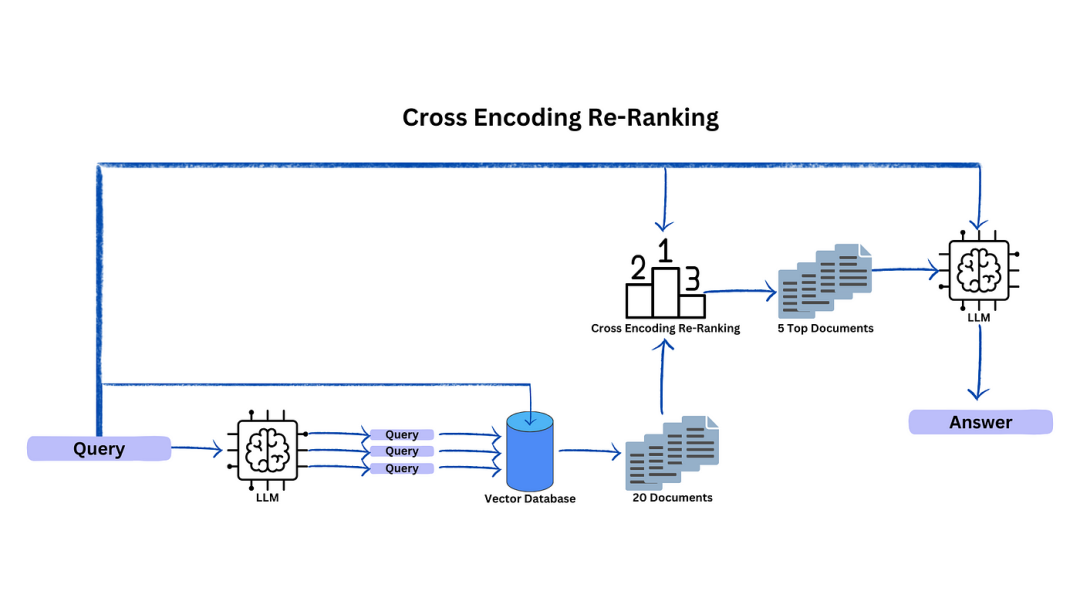

交叉编码是多查询和交叉编码器重新排序的结合，因为用户能够使用LLM生成更多的问题，每个生成的查询都能够从矢量数据库中提取出几个文档。这些提取的文档必须通过交叉编码器，以获得与初始查询的相似性分数。现在我们可以对相关文档进行重新排序，并选择前5名作为LLM摘要的上下文。

为什么我们需要选择前5个文档？在这种情况下，我们试图避免从矢量数据库中检索到不相关的文档，这种选择确保了交叉编码器专注于最相似和最有意义的文档，从而生成更准确、更简洁的摘要。

In [1]:
!pip install langchain langchain_community openai chromadb tiktoken langchainhub sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.1/324.1 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# 设置OpenAI KEY环境变量
import os
import getpass
os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key:')

OpenAI API Key:··········


In [3]:
#------------------------Prepare Vector Database--------------------------
# Build a sample vectorDB
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI
import os

# Load blog post
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()

llm = ChatOpenAI()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=0)
splits = text_splitter.split_documents(data)

# VectorDB
embedding = OpenAIEmbeddings()
vectordb = Chroma.from_documents(documents=splits, embedding=embedding)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [5]:
#--------------------Generate More Question----------------------------------
#This function use to generate queries using LLM
def create_original_query(original_query):
    query = original_query["question"]
    qa_system_prompt = """
            You are an AI language model assistant. Your task is to generate five
        different versions of the given user question to retrieve relevant documents from a vector
        database. By generating multiple perspectives on the user question, your goal is to help
        the user overcome some of the limitations of the distance-based similarity search.
        Provide these alternative questions separated by newlines."""

    qa_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", qa_system_prompt),
            ("human", "{question}"),
        ]
    )

    rag_chain = (
        qa_prompt
        | llm
        | StrOutputParser()
    )

    question_string = rag_chain.invoke(
        {"question": query}
    )

    lines_list = question_string.splitlines()
    queries = []
    queries = [query] + lines_list

    return queries

In [6]:
#-------------------Retrieve Document and Cross Encoding--------------------
from sentence_transformers import CrossEncoder
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
import numpy as np

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

#Cross Encoding happens in here
def create_documents(queries):
    retrieved_documents = []
    for i in queries:
        results = vectordb.as_retriever().get_relevant_documents(i)
        docString = [doc.page_content for doc in results]
        retrieved_documents.extend(docString)


    unique_a = []
    #If there is duplication documents for each query, make it unique
    for item in retrieved_documents:
        if item not in unique_a:
            unique_a.append(item)

    unique_documents = list(unique_a)

    pairs = []
    for doc in unique_documents:
        pairs.append([queries[0], doc])

    #Cross Encoder Scoring
    scores = cross_encoder.predict(pairs)

    final_queries = []
    for x in range(len(scores)):
        final_queries.append({"score":scores[x],"document":unique_documents[x]})

    #Rerank the documents, return top 5
    sorted_list = sorted(final_queries, key=lambda x: x["score"], reverse=True)
    first_five_elements = sorted_list[:6]
    return first_five_elements

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authenticatio

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [7]:
#-----------------QnA Document-----------------------------------------------
qa_system_prompt = """
        Assistant is a large language model trained by OpenAI. \
        Use the following pieces of retrieved context to answer the question. \
        If you don't know the answer, just say that you don't know. \

        {context}"""

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", qa_system_prompt),
        ("human", "{question}"),
    ]
)

def format(docs):
    doc_strings = [doc["document"] for doc in docs]
    return "\n\n".join(doc_strings)


chain = (
    # Prepare the context using below pipeline
    # Generate Queries -> Cross Encoding -> Rerank ->return context
    {"context": RunnableLambda(create_original_query)| RunnableLambda(create_documents) | RunnableLambda(format), "question": RunnablePassthrough()}
    | qa_prompt
    | llm
    | StrOutputParser()
)

result = chain.invoke({"question":"What Task Decomposition that work in 2022?"})

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [8]:
result

'In 2022, task decomposition involves breaking down large tasks into smaller, more manageable subgoals. This approach helps in planning over a lengthy history and facilitates the delegation of simple tasks to GPT-3.5 powered agents.'

参考从上面的langchain脚本，创建2个自定义函数用于生成查询和交叉编码。
create_original_query是生成查询，基本上会返回5个生成的问题加上原始查询。
create_documents将用于检索基于6个问题的24个相关文档。这24份相关文件将被复制，因此我们需要保留唯一的文件并删除重复的文件。